# NLBSE 2025 CS440 FInal Project

##### Team: Neural Network

##### Haobo Yuan yuan2000@colostate.edu

##### Kyle Young Kyle.Young@colostate.edu

## Project Introduction

The goal of this final project is on the multi-label classification task for code comments for NLBSE. We will be assigning appropriate labels to the functionality or purpose of the comments. The dataset's labels across multiple programming languages such as Java and Python.

The project leverages Natural Language Processing (NLP) techniques to extract features from code comments and classify them effectively. There are five main steps we separated the code into.

### **Step 1: Dataset Setup**

In [ ]:
!pip install datasets
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("NLBSE/nlbse25-code-comment-classification")

# Train and test splits
java_train = dataset["java_train"]
java_test = dataset["java_test"]

# Pandas easier to modify.
train = pd.DataFrame(java_train)
test = pd.DataFrame(java_test)

print("Sample Count in Training Set:", len(train))
print("Sample Count in Testing Set:", len(test))
print("Columns:", train.columns)

# Removing unnecessary lines.
train = train.dropna(subset=["comment_sentence"])
train = train[train["comment_sentence"].str.strip() != ""]
train = train.drop_duplicates(subset=["comment_sentence"])

print("Sample Count Cleaned:", len(train))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

java_train-00000-of-00001.parquet:   0%|          | 0.00/680k [00:00<?, ?B/s]

java_test-00000-of-00001.parquet:   0%|          | 0.00/174k [00:00<?, ?B/s]

python_train-00000-of-00001.parquet:   0%|          | 0.00/126k [00:00<?, ?B/s]

python_test-00000-of-00001.parquet:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

pharo_train-00000-of-00001.parquet:   0%|          | 0.00/113k [00:00<?, ?B/s]

pharo_test-00000-of-00001.parquet:   0%|          | 0.00/30.6k [00:00<?, ?B/s]

Generating java_train split:   0%|          | 0/7614 [00:00<?, ? examples/s]

Generating java_test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

Generating python_train split:   0%|          | 0/1884 [00:00<?, ? examples/s]

Generating python_test split:   0%|          | 0/406 [00:00<?, ? examples/s]

Generating pharo_train split:   0%|          | 0/1298 [00:00<?, ? examples/s]

Generating pharo_test split:   0%|          | 0/289 [00:00<?, ? examples/s]

Sample Count in Training Set: 7614
Sample Count in Testing Set: 1725
Columns: Index(['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'], dtype='object')
Sample Count Cleaned: 6608


### **Step 2: Data Augmentation and Balancing**

Here we are focus on handling the imbalance in the dataset to ensure all labels are represented. Class imbalance hinders the performance of these machine learning models, especially in regards to any minority classes. This step ensures effective learning for both the majority and minority classes in order to improve accuracy.

Label Distribution in Training Dataset:
Label_0    3334
Label_1     192
Label_2     467
Label_3    1659
Label_4     767
Label_5      81
Label_6     282
dtype: int64


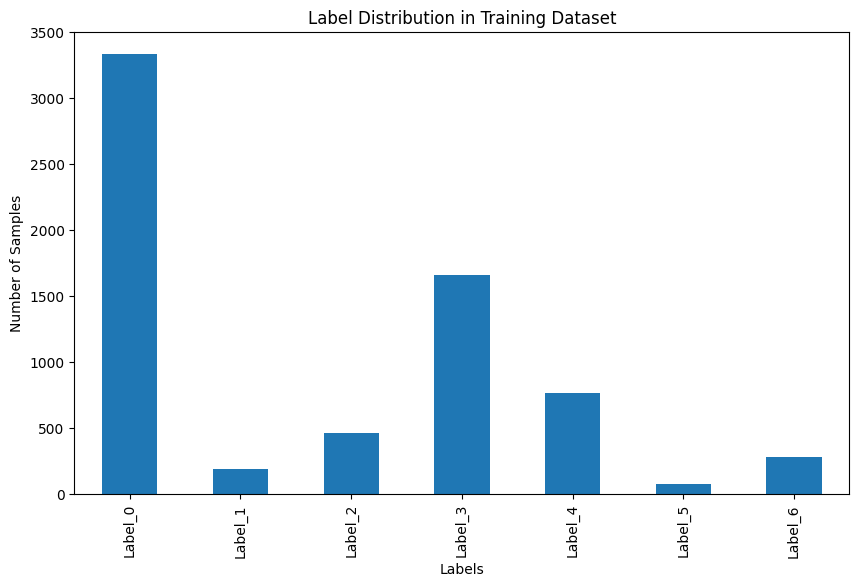

Sample Count in Balanced Training Dataset: 39474


In [ ]:
import matplotlib.pyplot as plt
from sklearn.utils import resample

# This expands the variable 'labels' into individual columns to make it better to work with.
labels = pd.DataFrame(train['labels'].to_list(), columns=[f"Label_{i}" for i in range(len(train['labels'][0]))])

totals = labels.sum(axis=0)
print("Label Distribution in Training Dataset:")
print(totals)

totals.plot(kind='bar', figsize=(10, 6))
plt.title("Label Distribution in Training Dataset")
plt.xlabel("Labels")
plt.ylabel("Number of Samples")
plt.show()

# Combine the DataFrames.
combined = pd.concat([train.reset_index(drop=True), labels], axis=1)

# Match majority and minority class in terms of samples.
balanced = []
for label in labels.columns:
    majority = combined[combined[label] == 0]
    minority = combined[combined[label] == 1]
    minority_upsampled = resample(minority,
                                  replace=True,
                                  n_samples=len(majority),
                                  random_state=42)
    balanced.append(minority_upsampled)

balanced = pd.concat(balanced)
print("Sample Count in Balanced Training Dataset:", len(balanced))
X_balanced = balanced['comment_sentence']
y_balanced = balanced.iloc[:, -len(labels.columns):]


### **Step 3: Extraction of Features**

This is two parts. First is the usage **TF-IDF (Term Frequency-Inverse Document Frequency)** for vectorizing the x data. For the y data, it's already basically ready, so we just used the .values method to make them easier to use.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vectorizing.
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_balanced_tf_idf = vectorizer.fit_transform(X_balanced)

y_balanced_labels = y_balanced.values

print("TF-IDF Feature Matrix Shape:", X_balanced_tf_idf.shape)
print("Label Matrix Shape:", y_balanced_labels.shape)


TF-IDF Feature Matrix Shape: (39474, 5505)
Label Matrix Shape: (39474, 7)


### **Step 4: Training the Model and Evaluating It**

Using the TF-IDF features to train a baseline model helps up evaluate its performance. Logistic Regression is the baseline classifier that we used.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

X_train, X_test, y_train, y_test = train_test_split(X_balanced_tf_idf, y_balanced_labels, test_size=0.2, random_state=42)

# Logistic Regression Model
log_regre = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
log_regre.fit(X_train, y_train)

y_pred = log_regre.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[f"Label_{i}" for i in range(y_train.shape[1])]))


Classification Report:
              precision    recall  f1-score   support

     Label_0       0.70      0.92      0.79       838
     Label_1       0.99      1.00      1.00      1302
     Label_2       0.87      0.98      0.93      1413
     Label_3       0.87      0.93      0.90      1154
     Label_4       0.94      0.99      0.96      1295
     Label_5       0.99      0.99      0.99      1307
     Label_6       0.89      0.98      0.93      1270

   micro avg       0.90      0.97      0.93      8579
   macro avg       0.89      0.97      0.93      8579
weighted avg       0.90      0.97      0.94      8579
 samples avg       0.92      0.97      0.94      8579



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### **Step 5: Optimizing the Model**

#### **Step Introduction**

Finally we optimize the baseline model to improve its performance.This includes tuning the hyperparameters, then experimenting with advanced models and finally addressing any specific issues that show up afterwards.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# Step 1: Hyperparameter tuning.
param_grid = {
    "estimator__C": [0.1, 1, 10, 100],
    "estimator__solver": ["lbfgs", "liblinear"],
    "estimator__class_weight": ["balanced", None]
}

grid_search = GridSearchCV(
    estimator=OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42)),
    param_grid=param_grid,
    scoring="f1_micro",
    cv=3
)

grid_search.fit(X_balanced_tf_idf, y_balanced_labels)

best_log_regre = grid_search.best_estimator_
print("Best Parameters for Logistic Regression:", grid_search.best_params_)

# Train Multi-Layer Perceptron (MLP) model.
mlp = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=300, random_state=42, early_stopping=True)
mlp.fit(X_balanced_tf_idf, y_balanced_labels)

print("Logistic Regression: Classification Report (Tuned):")
y_tuned = best_log_regre.predict(X_test)
print(classification_report(y_test, y_tuned, target_names=[f"Label_{i}" for i in range(y_test.shape[1])]))

print("MLP: Classification Report:")
y_mlp = mlp.predict(X_test)
print(classification_report(y_test, y_mlp, target_names=[f"Label_{i}" for i in range(y_test.shape[1])]))


Best Parameters for Logistic Regression: {'estimator__C': 10, 'estimator__class_weight': None, 'estimator__solver': 'liblinear'}
Logistic Regression: Classification Report (Tuned):
              precision    recall  f1-score   support

     Label_0       1.00      0.92      0.96       838
     Label_1       1.00      1.00      1.00      1302
     Label_2       0.99      0.98      0.99      1413
     Label_3       0.98      0.93      0.95      1154
     Label_4       0.99      0.99      0.99      1295
     Label_5       1.00      0.99      0.99      1307
     Label_6       0.99      0.98      0.99      1270

   micro avg       0.99      0.97      0.98      8579
   macro avg       0.99      0.97      0.98      8579
weighted avg       0.99      0.97      0.98      8579
 samples avg       0.97      0.97      0.97      8579

MLP: Classification Report:
              precision    recall  f1-score   support

     Label_0       1.00      0.99      0.99       838
     Label_1       1.00      1.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Step 5 Results Summary

#### **Logistic Regression (Tuned)**
- **Best Parameters**:
  - Regularization Strength (`C`): 10
  - Solver: `liblinear`
  - Class Weight: None (this means that the unbalanced weights performed better).
- **Performance**:
  - Precision, recall, and F1-scores are very high regardless of label.
  - Micro Avg: F1-score of 0.98 is high performance. Macro Avg and Weighted Avg do too.
  - Labels Label_0, Label_3, and Label_6 benefited with their F1-scores improving after being tuned.

#### **MLP Classifier**
- **Performance**:
  - Precision, recall, and F1-scores are high for all lavels.
  - Micro Avg: F1-score of 0.99 demonstrates the model's ability to handle multi-label classification effectively.
  - Macro Avg and Weighted Avg confirm high performance from all the labels.
  - Label recall improved over the tuned Logistic Regression.

#### **Comparison**
- **Logistic Regression**:
  - Slightly lower recall and F1-scores compared to MLP for certain labels.
  - An efficient baseline model with excellent performance.
- **MLP Classifier**:
  - Slightly better overall performance, especially with recall and F1-scores.
  - The more complex model led to higher computational needs.

The UndefinedMetricWarning warning occurs because some samples might have no predicted labels (true negatives). This doesn't effect the conclusion though, so these can be ignored. Just keep note of them.

#### **Steps and Their Results**
1. **Dataset Setup**:
   After loading datasets and cleaning the invalid data, we ended up with **6,608** training samples.

2. **Data Augmentation and Balancing**:
   - After balancing the dataset by oversampling minority classes, it resulted in **39,474** samples, qhich properly addressed the class imbalance.

3. **Extraction of Features**:
   Extracted features using TF-IDF, generating a feature matrix with a shape of **(39474, 5505)**. Then we created a target label matrix of **(39474, 7)** to represent the multi-label classification task.

4. **Training the Model and Evaluating It**:
   We trained with Logistic Regression as the baseline model and improved the model with hyperparameter tuning. Then we trained a Multi-Layer Perceptron (MLP) model, achieving even higher F1 scores.

5. **Optimizing the Model**:
   - The optimized Logistic Regression achieved an F1 score of **0.98**, which is great performance, but we were able to improve it with the MLP model at it slightly improved further with an F1 score of **0.99** and better recall performance.

---

#### **What We Found**
- Oversampling significantly improved classification performance for minority labels, enhancing recall for labels like Label_1 and Label_5.
- The baseline model (Logistic Regression) provided strong and reliable classification results.
- The MLP model captured more complex feature patterns, achieving superior overall performance.